building noise mnist...
save noise mnist...
imgs shape: (16, 28, 28)


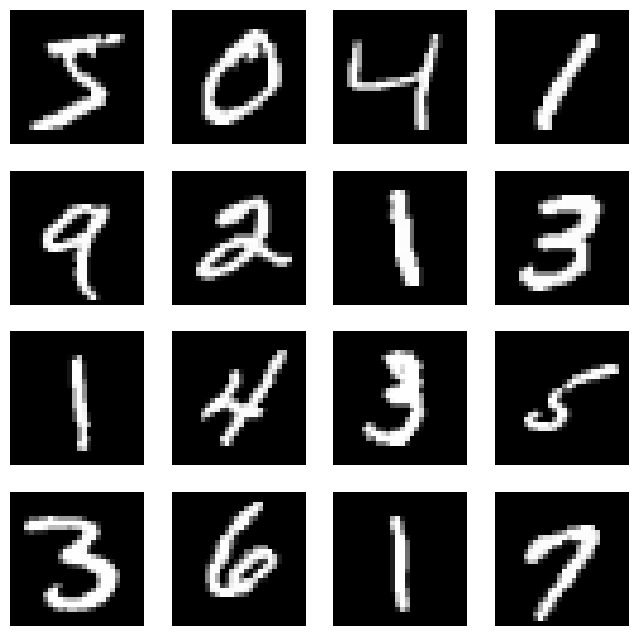

imgs shape: (16, 28, 28)


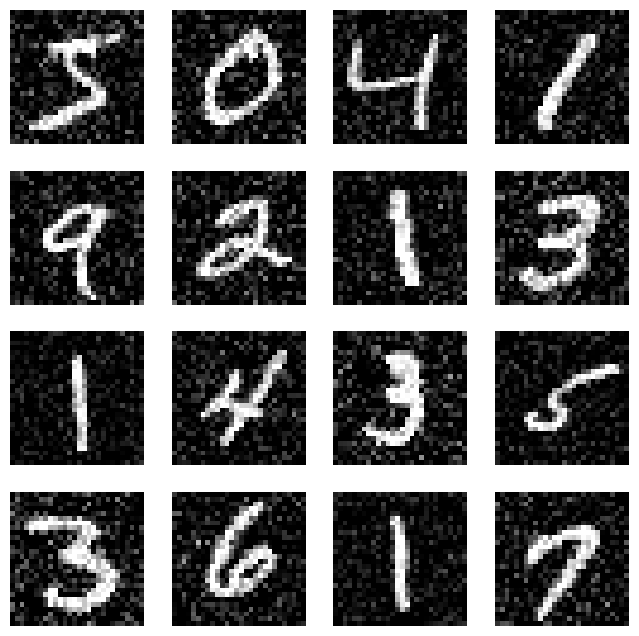

60000 train samples
10000 test samples


In [2]:
"""
PRIA version
Additive white Gaussian noise (AWGN)
"""

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np


# generate noise
def wgn(x, snr):
    """
    SNR: signal to noise ratio
        https://en.wikipedia.org/wiki/Signal-to-noise_ratio
    """
    _shape = x.shape
    x = x.ravel()
    snr = 10 ** (snr / 10.0)
    xpower = np.sum(x ** 2) / len(x)
    npower = xpower / snr
    return (np.random.randn(len(x)) * np.sqrt(npower)).reshape(_shape)


# add noise to x
def awgn(x, snr=5, clip=[0, 1]):
    """
    x: value in [0,1] instead of [0,255]
    """
    min_, max_ = clip
    return np.clip(x + wgn(x, snr), min_, max_)


# convert raw dataset to noise dataset
def to_noise_dataset(X, snr, clip=[0, 1]):
    """
    X: value in [0,1] instead of [0,255]
    """
    return np.array([awgn(x, snr, clip) for x in X], dtype=X.dtype)


# convert mnist to awgn mnise
def build_mnist_awgn(snr):
    """
    return value in [0,255]
    """
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
    raw_x_train = raw_x_train.astype('float')
    raw_x_test = raw_x_test.astype('float')
    raw_x_train /= 255
    raw_x_test /= 255

    x_train = (to_noise_dataset(raw_x_train, snr) * 255).astype(np.uint8)
    y_train = raw_y_train
    x_test = (to_noise_dataset(raw_x_test, snr) * 255).astype(np.uint8)
    y_test = raw_y_test
    return (x_train, y_train), (x_test, y_test)


# %% load local datset function
def load_mnist_noise(path):
    if path[-4:] == '.mat':  # matlab file [1]
        f = sio.loadmat(path)
        x_train, y_train = f['train_x'], f['train_y']
        x_test, y_test = f['test_x'], f['test_y']
    elif path[-4:] == '.npz':  # numpy zip
        f = np.load(path)
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    else:
        raise ValueError('only support `.mat` or `.npz` file')
    return (x_train, y_train), (x_test, y_test)


# show example images
def showimg(img, cmap='gray'):
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()


def showimgs(imgs, nrows, ncols, figsize=(12, 12), cmap='gray'):
    print('imgs shape:', imgs.shape)
    assert (imgs.shape[0] == nrows * ncols)
    newshape = (nrows, ncols) + imgs.shape[1:]
    imgs = imgs.reshape(newshape)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    # fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    for i in range(nrows):
        for j in range(ncols):
            img = imgs[i, j, ...]
            axs[i, j].axis('off')
            axs[i, j].imshow(img, cmap=cmap)
    plt.show()


# %% run awgn
if __name__ == '__main__':
    # SNR = 3  #signal noise ratio, smaller value then stronger noise
    SNR = 5
    # SNR = 0.5

    # load images as (?, 784) shape
    # fname_mat = 'mnist-pria-awgn.mat'
    fname_npz = 'mnist-pria-awgn_snr=%s.npz' % str(SNR)
    save_compressed = False

    if os.path.exists(fname_npz):
        (x_train, y_train), (x_test, y_test) = load_mnist_noise(fname_npz)
    else:
        print('building noise mnist...')
        (x_train, y_train), (x_test, y_test) = build_mnist_awgn(snr=SNR)
        print('save noise mnist...')
        if save_compressed:
            np.savez_compressed(fname_npz, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
        else:
            np.savez(fname_npz, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

# show first 16 images
if __name__ == '__main__':
    show_size = (8, 8)
    m = 4
    m2 = m * m

    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
    raw_x_train_show = raw_x_train[:m2].reshape(-1, 28, 28)
    showimgs(raw_x_train_show, m, m, figsize=show_size)
    x_train_show = x_train[:m2].reshape(-1, 28, 28)
    showimgs(x_train_show, m, m, figsize=show_size)

    num_classes = 10
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')


In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

def train_model():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    # 1x28x28
    # Encoder 使用卷積層，激活函數用 relu，輸入的維度就是上面定義的 input_img
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    # 16@28x28
    x = MaxPooling2D((2, 2), padding='same')(x)
    # 16@14x14
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    # 8@14X14
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)
    # 8@7x7    
    
    # Decoder 的過程與 Encoder 正好相反，需要跟 Encoder 的神經網絡層做相對應，相對應的激活函數也是一樣，
    # 但這邊在解碼中最後一層使用的激活函數是 sigmoid
    # 8@7x7
    x = UpSampling2D((2, 2))(encoded)
    # 8@14X14
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # 16@14X14
    x = UpSampling2D((2, 2))(x)
    # 16@28x28
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)    
    # 1@28x28
    # 1x28x28
    
    # 用 Model 來搭建模型，輸入為圖片，輸出是解碼的結果
    autoencoder = Model(input_img, decoded)  
    
    # 編譯模型，optimizer 使用 adam，loss 使用 binary_crossentropy
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    # 訓練 Denoising AE ，輸入是加入雜訊的圖片，輸出是原始圖片
    autoencoder.fit(x_train, raw_x_train,
                    epochs=20,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, raw_x_test),
                    callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

    autoencoder.save('autoencoder.h5')  # 與官方有點不同的是，多做了保存模型的動作

train_model()

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
469/469 [==============================] - ETA: 0s - loss: 440.2022WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000285DCC8DCA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the 

In [8]:
def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
    test_img = x_test[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    cv2.imshow('input', resized_test_img)
    cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    cv2.imshow('output', resized_output)
    cv2.waitKey(0)

In [9]:
x_test.shape[0]

10000

In [10]:
x_test.shape[1]

28

In [11]:
x_test.shape[2]

28

In [12]:
plot_denoised_images()

NameError: name 'autoencoder' is not defined